In [34]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

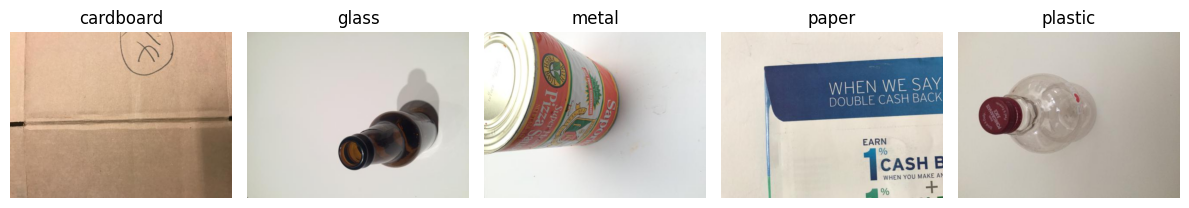

In [35]:
import os
import matplotlib.pyplot as plt
from PIL import Image
dataset_dir = r"D:\AICTE INTERNSHIP\projectdataset\TrashType_Image_Dataset"
class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_folders[:5]):
    class_path = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_path)
    if not image_files:
        continue
    image_path = os.path.join(class_path, image_files[0])
    image = Image.open(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [36]:
image_size=(124,124)
batchsize=32
seed=42


In [37]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    image_size=image_size,
    batch_size=batchsize,
    seed=42,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [38]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    image_size=image_size,
    batch_size=batchsize,
    seed=42,
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [56]:
val_batches=tf.data.experimental.cardinality(test_ds)
oneval=test_ds.take(val_batches//2)
twoval=test_ds.skip(val_batches//2)
twovaleval=twoval.cache().prefetch(tf.data.AUTOTUNE)

In [40]:
print(train_ds.class_names)
print(test_ds.class_names)
print("No.of Classses are ",len(test_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
No.of Classses are  6


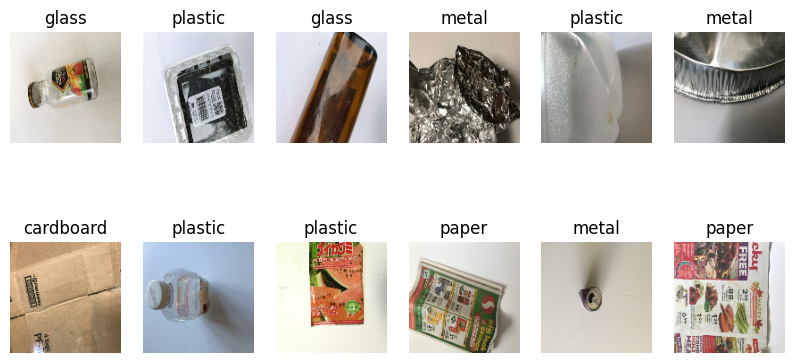

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [42]:
def count_distribution(dataset,names):
    total=0
    counts={name:0 for name in names}
    for _,labels in dataset:
        for i in labels.numpy():
            class_name=names[i]
            counts[class_name]+=1
            total+=1
    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  
    return counts
    

In [43]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [44]:
class_names=train_ds.class_names
train_dist=count_distribution(train_ds,class_names)
test_dist=count_distribution(test_ds,class_names)
oneval_dist=count_distribution(oneval,class_names)
twoval_dist=count_distribution(twoval,class_names)
print(train_dist)
print(test_dist)
print(oneval_dist)
print(twoval_dist)


{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 12.85, 'glass': 22.09, 'metal': 16.06, 'paper': 26.51, 'plastic': 17.27, 'trash': 5.22}


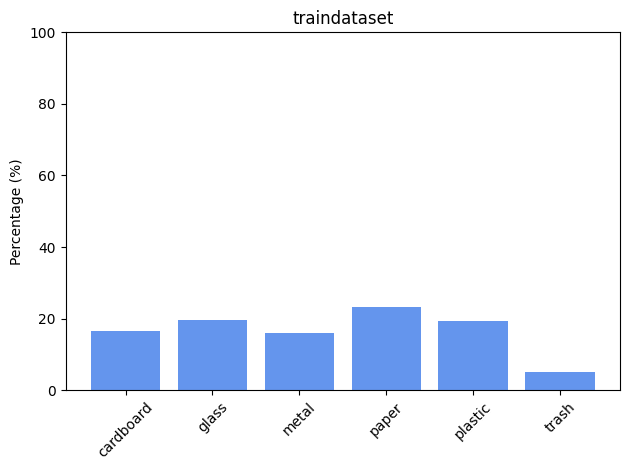

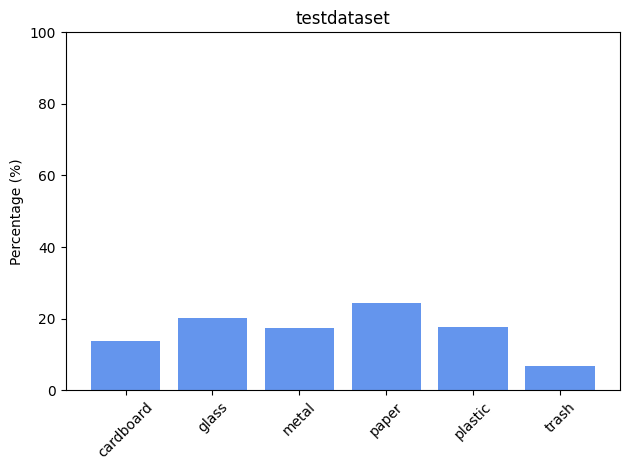

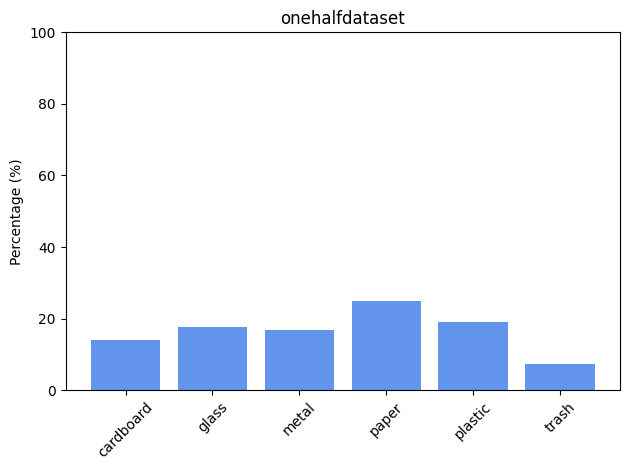

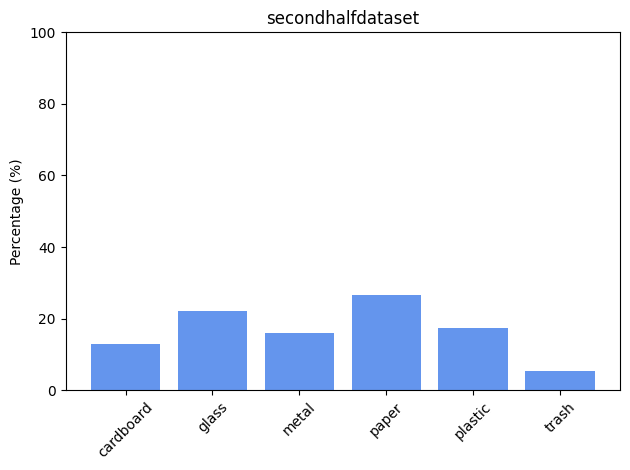

In [45]:
simple_bar_plot(train_dist,'traindataset')
simple_bar_plot(test_dist,'testdataset')
simple_bar_plot(oneval_dist,'onehalfdataset')
simple_bar_plot(twoval_dist,'secondhalfdataset')

In [46]:
class_counts={i:0 for i in range(len(class_names))}
alllabels=[]
for images,labels in train_ds:
    for label in labels.numpy():
        class_counts[label]+=1
        alllabels.append(label)
classweightsarray=compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=alllabels
)
classweights={x:w for x,w in enumerate(classweightsarray)}


In [47]:
print(classweights)
print(class_counts)

{0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}
{0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}


In [48]:

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [49]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:200]:
    layer.trainable = False

In [50]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  
])

In [51]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          
    patience=3,                  
    restore_best_weights=True    
)


In [53]:

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    class_weight=classweights,
    callbacks=[early]
)


Epoch 1/15


64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 837ms/step - accuracy: 0.3022 - loss: 1.7134 - val_accuracy: 0.6356 - val_loss: 1.1681
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 759ms/step - accuracy: 0.6793 - loss: 1.0697 - val_accuracy: 0.7525 - val_loss: 0.8093
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 772ms/step - accuracy: 0.7881 - loss: 0.7191 - val_accuracy: 0.8455 - val_loss: 0.5945
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 760ms/step - accuracy: 0.8242 - loss: 0.5449 - val_accuracy: 0.8594 - val_loss: 0.4947
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 761ms/step - accuracy: 0.8854 - loss: 0.4014 - val_accuracy: 0.8713 - val_loss: 0.4302
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 785ms/step - accuracy: 0.8976 - loss: 0.3315 - val_accuracy: 0.8752 - val_loss: 0.3793
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 831ms/step - accuracy: 0.9244 - loss: 0.2637 - val_accuracy: 0.8713 - val_loss: 0.3708
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 746ms/step - accuracy: 0.9294 - loss: 0.2249 - val_accuracy: 0.883

In [54]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 124, 124,  │          0 │ input_layer_11[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 124, 124,  │          0 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 6,499,826 (24.79 MB)

 Non-trainable params: 2,269,548 (8.66 MB)

In [57]:
loss, accuracy = model.evaluate(twovaleval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.8842 - loss: 0.3624
Test accuracy is0.8956, Test loss is 0.2879


In [61]:
y_true = np.concatenate([y.numpy() for x, y in twovaleval], axis=0)
y_pred_probs = model.predict(twovaleval)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
[[28  0  0  3  0  1]
 [ 0 41  3  0  3  0]
 [ 0  0 44  0  1  1]
 [ 3  0  1 48  1  5]
 [ 0  2  0  1 45  1]
 [ 0  0  0  0  0 17]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.95      0.87      0.91        47
           2       0.92      0.96      0.94        46
           3       0.92      0.83      0.87        58
           4       0.90      0.92      0.91        49
           5       0.68      1.00      0.81        17

    accuracy                           0.90       249
   macro avg       0.88      0.91      0.89       249
weighted avg       0.90      0.90      0.90       249



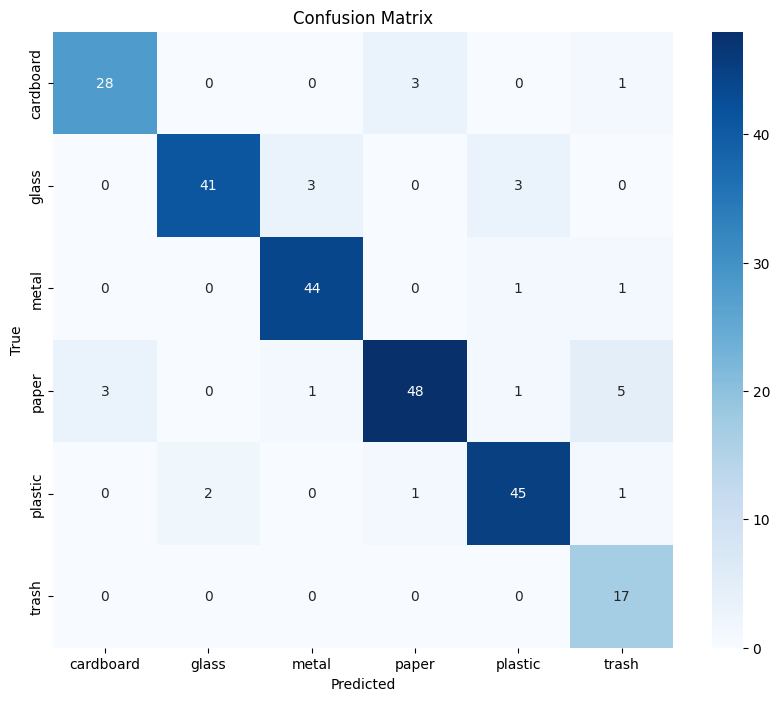

In [ ]:
plt.figure(figsize=(10,8)) 

sns.heatmap(cm, annot=True, fmt='d',  
            xticklabels=class_names,  
            yticklabels=class_names,  
            cmap='Blues')  

plt.xlabel('Predicted') 
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.show()  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


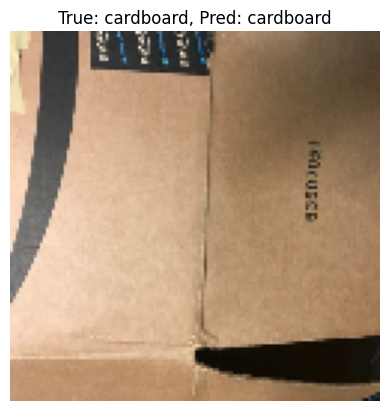

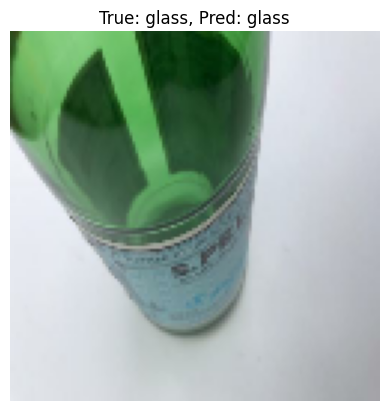

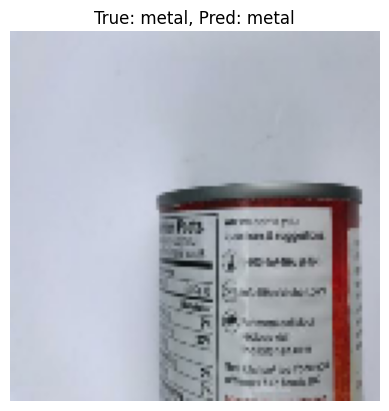

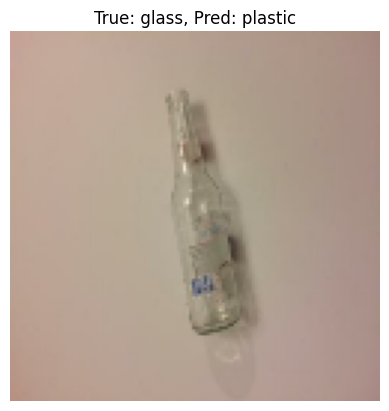

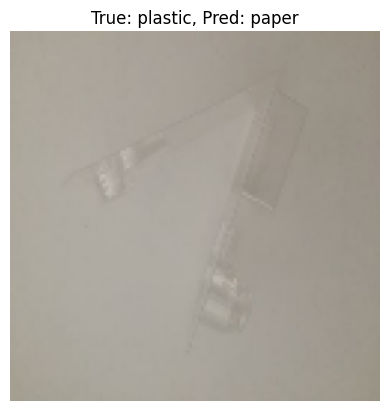

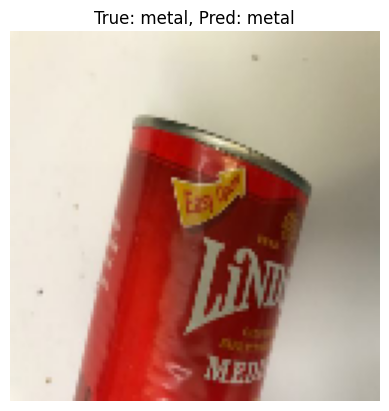

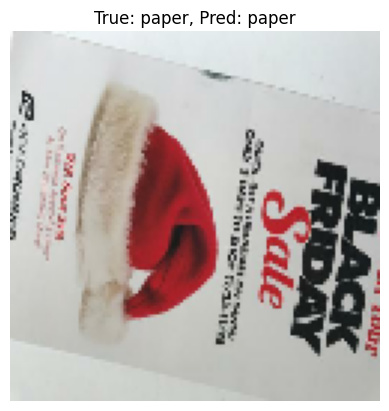

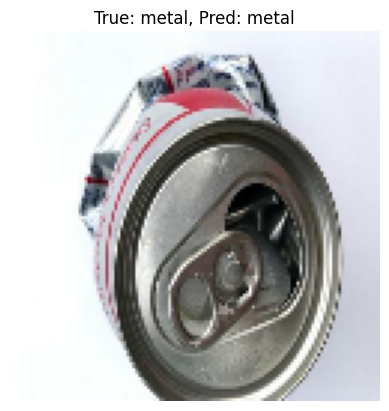

In [62]:
class_names = train_ds.class_names

for images, labels in twovaleval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [63]:

model.save('Effiicientnetv2b2.keras')
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')